In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import zipfile
import io

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.weights = []
        self.biases = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i+1]))
            self.biases.append(np.random.randn(sizes[i+1]))
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    def compute_loss(self, y_true, y_pred):
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return loss
    def forward(self, x):
        activations = [x]
        for i in range(len(self.weights)):
            x = np.dot(x, self.weights[i]) + self.biases[i]
            if i == len(self.weights) - 1:
                x = self.softmax(x)
            else:
                x = self.sigmoid(x)
            activations.append(x)
        return activations
    def backward(self, x, y, activations, learning_rate):
        batch_size = x.shape[0]
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        gradients_b = [np.zeros(b.shape) for b in self.biases]
        error = activations[-1] - y
        gradients_w[-1] = np.dot(activations[-2].T, error) / batch_size
        gradients_b[-1] = np.mean(error, axis=0)
        for i in range(2, len(self.weights) + 1):
            error = np.dot(error, self.weights[-i+1].T) * activations[-i] * (1 - activations[-i])
            gradients_w[-i] = np.dot(activations[-i-1].T, error) / batch_size
            gradients_b[-i] = np.mean(error, axis=0)
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * gradients_w[i]
            self.biases[i] -= learning_rate * gradients_b[i]
    def train(self, x_train, y_train, x_val, y_val, epochs, batch_size, learning_rate):
      train_losses = []
      val_losses = []
      val_accuracies = []
      for epoch in range(epochs):
          print(f"Epoch {epoch+1}/{epochs}")
          indices = np.arange(len(x_train))
          np.random.shuffle(indices)
          x_train_shuffled = x_train[indices]
          y_train_shuffled = y_train[indices]
          for i in range(0, len(x_train), batch_size):
              x_batch = x_train_shuffled[i:i+batch_size]
              y_batch = y_train_shuffled[i:i+batch_size]
              activations = self.forward(x_batch)
              self.backward(x_batch, y_batch, activations, learning_rate)
          train_activations = self.forward(x_train)
          train_loss = self.compute_loss(y_train, train_activations[-1])
          train_losses.append(train_loss)
          val_activations, val_preds = self.predict(x_val)
          val_loss = self.compute_loss(y_val, val_activations[-1])
          val_losses.append(val_loss)
          val_acc = accuracy_score(np.argmax(y_val, axis=1), val_preds)
          val_accuracies.append(val_acc)
          print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
      return train_losses, val_losses, val_accuracies
    def predict(self, x):
        activations = self.forward(x)
        preds = np.argmax(activations[-1], axis=1)
        return activations, preds

In [ ]:
from PIL import Image
def load_data_from_zip(zip_file):
    labels = {'tulip': 0, 'sunflower': 1, 'rose': 2, 'dandelion': 3, 'daisy': 4}
    images = []
    labels_list = []
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        for label, index in labels.items():
            print(f"Loading images for label: {label}")
            for filename in zip_ref.namelist():
                if label in filename and filename.startswith('flowers/') and not filename.endswith('/'):
                    with zip_ref.open(filename) as file:
                        try:
                            img_bytes = file.read()
                            img_nparr = np.frombuffer(img_bytes, np.uint8)
                            img = cv2.imdecode(img_nparr, cv2.IMREAD_COLOR)
                            img = cv2.resize(img, (100, 100))
                            img = img.astype('float32') / 255.0
                            images.append(img)
                            labels_list.append(index)
                        except Exception as e:
                            print(f"Error processing image file: {filename}")
                            print(e)
    print(f"Number of images loaded: {len(images)}")
    print(f"Number of labels loaded: {len(labels_list)}")
    return np.array(images), np.array(labels_list)

In [ ]:
zip_file = 'flowers.zip'
images, labels = load_data_from_zip(zip_file)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Loading images for label: tulip
Loading images for label: sunflower
Loading images for label: rose
Loading images for label: dandelion
Loading images for label: daisy
Number of images loaded: 4317
Number of labels loaded: 4317


In [ ]:
mlp = MLP(input_size=100*100*3, hidden_sizes=[128, 64], output_size=5)

In [ ]:
train_losses, val_losses, val_accuracies = mlp.train(x_train.reshape(-1, 100*100*3), np.eye(5)[y_train],
                                                     x_val.reshape(-1, 100*100*3), np.eye(5)[y_val],
                                                     epochs=10, batch_size=32, learning_rate=0.01)

Epoch 1/10
Validation Loss: 2.636865715896817, Validation Accuracy: 0.19826338639652677
Epoch 2/10
Validation Loss: 2.3190390266216556, Validation Accuracy: 0.2402315484804631
Epoch 3/10
Validation Loss: 2.2015276974783986, Validation Accuracy: 0.24167872648335745
Epoch 4/10
Validation Loss: 2.113513036638116, Validation Accuracy: 0.22865412445730826
Epoch 5/10
Validation Loss: 2.044267620602705, Validation Accuracy: 0.23878437047756873
Epoch 6/10
Validation Loss: 2.001181653236984, Validation Accuracy: 0.24457308248914617
Epoch 7/10
Validation Loss: 1.9596846238192633, Validation Accuracy: 0.25470332850940663
Epoch 8/10
Validation Loss: 1.924621005236707, Validation Accuracy: 0.23589001447178004
Epoch 9/10
Validation Loss: 1.8989567300669385, Validation Accuracy: 0.2460202604920405
Epoch 10/10
Validation Loss: 1.8731333225342988, Validation Accuracy: 0.25615050651230103


In [ ]:
test_activations, test_preds = mlp.predict(x_test.reshape(-1, 100*100*3))
test_acc = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_acc}")
print(classification_report(y_test, test_preds))

Test Accuracy: 0.28587962962962965
              precision    recall  f1-score   support

           0       0.33      0.29      0.31       205
           1       0.22      0.19      0.20       160
           2       0.29      0.18      0.22       153
           3       0.31      0.53      0.39       195
           4       0.22      0.17      0.19       151

    accuracy                           0.29       864
   macro avg       0.27      0.27      0.26       864
weighted avg       0.28      0.29      0.27       864



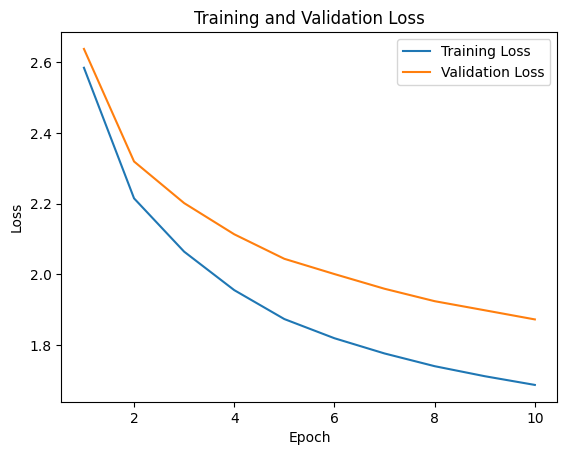

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(np.eye(5)[y_test][:, i], test_activations[-1][:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

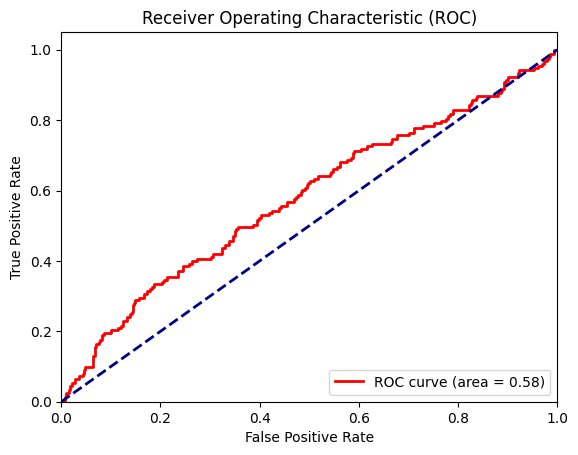

In [ ]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()